##  Optimze and a Dense Neural Network for gap filling and feature identification

** With a few tweaks to RepRunner, an LSTM can be run instead

In [28]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
# from functools import partial
from multiprocessing import Pool
from functools import partial
from sklearn import metrics
# from sklearn.model_selection import train_test_split

## Personal Modules
import ReadStandardTimeFill as RSTF
import importlib
import DenseNet as Dense
import MiscFuncs as MF
importlib.reload(Dense)
importlib.reload(RSTF)
importlib.reload(MF)

# %matplotlib inline

%matplotlib notebook
%config IPCompleter.greedy=True

from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from sklearn.externals import joblib
from matplotlib import cm

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

from ipywidgets import FloatProgress, HTML
from IPython.display import display, clear_output
import os  
import shutil
from keras import backend as K
try:pool.close()
except:pass


def Test(params,X,y,YScaled,XScaled,pool):
    return(np.random.rand(params['K']))


def ModSelect(Scope,Site):
    if Site == 'Illisarvik':
        if Scope == 'Full':
            Model = ['wind_speed','(z-d)/L','PPFD_Avg','AirTC_Avg','VPD',
                    'Temp','VWC','Sedge','Shrub','Grass','Upland']
        if Scope == 'Test':
            Model = ['wind_dir','wind_speed','AirTC_Avg',
                    'Temp','VWC','Sedge','Upland']
#             Model = ['Temp','VWC','Sedge','Upland','VPD','PPFD_Avg']
#         if Scope == 'Test':
#             Model = ['PPFD_Avg','Sedge','Sparse']#,'VPD','wind_speed']
    if Site == 'FishIsland':
        BaseFactors = []
        if Scope == 'Full':
            Model = ['H','Wind Spd','air pressure','Ta','Rn','PPFD','Rain','Water Table',
            'Ts 2.5 cm','Ts 15 cm','VWC','Active Layer','24H Rain','Wtr Tbl Trnd']
        if Scope == 'Test':
            Model = ['H','Water Table','Wind Spd','Active Layer']
    return(Model)

def Combos(Model,L,factor=None):
    Models=[]
    for c in combinations(Model,L):
        c = list(c)
        if factor is None:
            Models.append(c)
        else:
            for f in factor:
                f = f.split('+')
                if set(f).issubset(set(c)) and c not in Models:
                    Models.append(c)
                    
#     print('Models: ',Models)
    return(Models)

def Stats(mse,se,j,i,params):
    df = pd.DataFrame(index = [str(j)+'_'+str(i)],
                      data={'Model':[params['Model']],
                            'MSE':[mse],
                            'Size':j,
                            'Number':i,
                            'SE':[se],
                            'Performance':0})
    return(df)

def t(p,n):
    alpha = 1-p
    df = n-1
    return(stats.t.ppf(alpha,df))

FirstRun = True
# FirstRun = False

MP=True
# MP=False
Scope = 'Full'
if Scope == Test:
    processes=2
else:
    processes=4
    
cwd = os.getcwd()
# for Site in ['Illisarvik','FishIsland']:
Site='Illisarvik'
target='fch4'
alpha = .05
print(cwd)


pd.set_option('max_colwidth',200)
def Display (tar,prog1,prog2,MdLs,MdL,kwt):
    clear_output()
    display(tar)
    display(prog1)
    display(prog2)
    display(MdLs)
    display(MdL)
    display(kwt)
    
tar = HTML(
            value=" ",
            placeholder='Target: ',
            description='Target: ',
        )
kwt = HTML(
        value=str(0),
        placeholder='Quit Score: ',
        description='Quit Score: ',
        )

C:\Users\wesle\NetworkAnalysis


# Model

In [29]:

Time = time.time()

kwit = 0
if __name__ == '__main__':
    for target in ['fco2','fch4','ER']:
        XVarriables=ModSelect(Scope,Site)
        if FirstRun == True:
            start=1
            stop = len(XVarriables)
            try:shutil.rmtree(cwd+'/'+Site+'/'+target+'/')
            except:pass
            os.mkdir(cwd+'/'+Site+'/'+target+'/')
        else:
            params = Dense.Params(Scope,target,MP)
            params['Dpath'] = cwd+'/'+Site+'/'
            Records = pd.read_csv(cwd+'/'+Site+'/'+target+'_Runs.csv',delimiter = ',',header = 0,index_col=[0])
            start = 2#Records['Size'].max()+1
            Level = Records.loc[Records['Size']==start-1]
            Min = Level.loc[Level['MSE']==Level['MSE'].min()]
            Sv = (((Level['SE']**2+Min['SE'].values[0]**2)/2)**.5)
            Level['T']=(Level['MSE']-Min['MSE'].values[0])/(Sv*(2/params['K'])**.5)
            Factors = Level.loc[Level['T']<=stats.t.ppf(1-alpha,params['K']),'Model'].values
            Level.loc[Level['T']<=stats.t.ppf(1-alpha,params['K']),'Performance']=1
            
            stop = len(XVarriables)
            if start >2:
                Last = Records.loc[Records['Size']==start-2].sort_values('MSE').reset_index()
                Rec = Last.loc[Last['MSE']==Last['MSE'].min()]
                Sv = (((Level['SE']**2+Rec['SE'].values[0]**2)/2)**.5)
                Level['T2']=(Level['MSE']-Rec['MSE'].values[0])/(Sv*(2/params['K'])**.5)

                Level.loc[Level['T2']<=-stats.t.ppf(1-alpha,params['K']),'Performance']+=1
                Factors = Level.loc[Level['Performance']>=2,'Model'].values
            print(Records)
                      
        kwt = HTML(
                    value=str(0),
                    placeholder='Quit Score: ',
                    description='Quit Score: ',
                )
        tar.value=target
#         XVarriables=ModSelect(Scope,Site)
        prog1 = FloatProgress(min=start, max=stop,description='Running:')
        prog2 = FloatProgress(min=0, max=100,description='Bootstrapping:')
        MdLs = HTML(
            value=" ",
            placeholder='Models: ',
            description='Models: ',
        )
        MdL = HTML(
            value=" ",
            placeholder='Testing: ',
            description='Testing: ',
        )
        Display (tar,prog1,prog2,MdLs,MdL,kwt)
        for j in range(start,stop):
            if j == 1: Inputs = (Combos(XVarriables,j))
            else: Inputs = (Combos(XVarriables,j,Factors))
            MdLs.value=str(len(Inputs))
            i = 0
            procede = True
            for Input in Inputs:
                if FirstRun == False:
                    print(Records.isin({'Size':[j]}).any().any())
                    if Records.loc[Records['Size']==j].isin({'Number':[i]}).any().any()==True:
                        procede = False
                    else:
                        procede = True
#                 if Input == ''
                    
                if procede == True:
                    params = Dense.Params(Scope,target,MP)
                    params['Dpath'] = cwd+'/'+Site+'/'
                    params['Spath'] = params['Dpath']+'/'+target+'/'+str(j)+'_'+str(i)+'/'
                    try:os.mkdir(params['Spath'])
                    except:pass
                    params['Sname'] = 'Y_'
                    params['Inputs'] = Input
                    MdL.value='#'+str(i)+' '+str(params['Inputs'])
                    Display (tar,prog1,prog2,MdLs,MdL,kwt)
                    try:
                        print(Level.sort_values('MSE'))
                    except:
                        pass
                    print('Runtime: ',time.time()-Time)
                    params['Model'] = '+'.join(params['Inputs'])
                    RST = RSTF.ReadStandardTimeFill(params,'ECData.csv')#,resample='2H')
#                     if target == 'fco2':
#                         RST.Master = RST.Master.loc[RST.Master['PPFD_Avg']<10]
                    RST.Scale(params['target'],params['Inputs']) 
                    y = RST.y*1.0
                    X = RST.X*1.0
                    params['N']=int(y.shape[0]/30)
                    params['Memory'] = (math.floor(100/params['proc'])- 5/params['proc']) * .01
                    Y_hat=[]
                    y_true=[]
                    X_true=[]
                    index=[]
                    ones=[]
                    prog2.value=0
#                     if MP == False:
#                         for k in range(params['K']):
#                             Time2 = time.time()
#                             results = Dense.Bootstrap(k,params,X,y)
#                             Y_hat.append(RST.YScaled.inverse_transform(results[0]))
#                             y_true.append(RST.YScaled.inverse_transform(results[1]))
#                             X_true.append(RST.XScaled.inverse_transform(results[2]))
#                             ones.append(results[3])
#                             prog2.value=(k+1)/params['K']*100
#                             print(time.time()-Time2)
#                     else:
                    pool = Pool(processes=processes,maxtasksperchild=75)
                    for k,results in enumerate(pool.imap(partial(Dense.Bootstrap,params=params,X=X,y=y),range(params['K']))):
                        Y_hat.append(RST.YScaled.inverse_transform(results[0]))
                        y_true.append(RST.YScaled.inverse_transform(results[1]))
                        X_true.append(RST.XScaled.inverse_transform(results[2]))
                        ones.append(results[3])
                        prog2.value=(k+1)/params['K']*100
                    pool.close()
                    Y_hat = np.squeeze(np.asanyarray(Y_hat))
                    y_true = np.squeeze(np.asanyarray(y_true))
                    X_true = np.asanyarray(X_true)
                    ones = np.asanyarray(ones)
                    params['Memory'] = .95
#                     if MP == False:
#                         for k in range(1):
#                              mse,se = Dense.Sort_outputs(k,params,Y_hat,y_true,X_true,ones)
#                     else:
                    pool = Pool(processes=1,maxtasksperchild=75)
                    for k,results in enumerate(pool.imap(partial(Dense.Sort_outputs,params=params,
                     Y_hat=Y_hat,y_true=y_true,X_true=X_true,ones=ones),range(1))):
                         mse,se = results
                    pool.close()
                    if i == 0 and FirstRun == True:Level = Stats(mse,se,j,i,params)
                    else:
                        Level = Level.loc[Level['Size']==j]
                        Level = Level.append(Stats(mse,se,j,i,params))
                i += 1
                prog1.value=j+i/len(Inputs)
#             Min = Level.loc[Level['MSE']==Level['MSE'].min()]
            if j ==1:
#         ch4.Records.loc[fch4.Records['Size']==level-1].sort_values('MSE').reset_index()
                Min = Level.loc[Level['MSE']==Level['MSE'].min()]
#                 Level['T']
                
                Sv = (((Level['SE']**2+Min['SE'].values[0]**2)/2)**.5)
                Level['T']=(Level['MSE']-Min['MSE'].values[0])/(Sv*(2/params['K'])**.5)
                Level['T2'] = Level['T']
                Level.loc[Level['T']<=stats.t.ppf(1-alpha,params['K']),'Performance']=1
                Factors = Level.loc[Level['Performance']==1,'Model'].values
            else:

                Min = Level.loc[Level['MSE']==Level['MSE'].min()]
                Sv = (((Level['SE']**2+Min['SE'].values[0]**2)/2)**.5)
                Level['T']=(Level['MSE']-Min['MSE'].values[0])/(Sv*(2/params['K'])**.5)
#                 Level['T2'] = Level['T']
                Factors = Level.loc[Level['T']<=1.67,'Model'].values
                Level.loc[Level['T']<=stats.t.ppf(1-alpha,params['K']),'Performance']=1
                
                Last = Records.loc[Records['Size']==j-1].sort_values('MSE').reset_index()
                Rec = Last.loc[Last['MSE']==Last['MSE'].min()]
                
                Sv = (((Level['SE']**2+Rec['SE'].values[0]**2)/2)**.5)
                Level['T2']=(Level['MSE']-Rec['MSE'].values[0])/(Sv*(2/params['K'])**.5)
                
#                 Factors2 = Level.loc[Level['T2']<=-1.67,'Model'].values
                Level.loc[Level['T2']<=-stats.t.ppf(1-alpha,params['K']),'Performance']+=1
                Factors = Level.loc[Level['Performance']>=2,'Model'].values
            if j == 1:
                Records = Level
            else:
                Records = Records.append(Level)
            kwt.value = str(kwit)
            Records = Records.reset_index(drop=True)
            Records.drop(Records.columns[Records.columns.str.contains('Unnamed',case = False)],axis = 1)
            if Scope == 'Full':
                Records.to_csv(params['Dpath']+'/'+target+'_Runs.csv')
            else:
                Records.to_csv(params['Dpath']+'/'+target+'_Runs2.csv')
            print(Level)
            if Level['Performance'].max()<2 and j>1:
                break

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

                     Model       MSE  Size  Number        SE  Performance
2_25             VPD+Shrub  0.012717     2      25  0.005526            0
2_23               VPD+VWC  0.013396     2      23  0.010685            0
2_11          PPFD_Avg+VPD  0.013583     2      11  0.006087            0
2_24             VPD+Sedge  0.013620     2      24  0.006322            0
2_1         wind_speed+VPD  0.013622     2       1  0.007717            0
2_20       AirTC_Avg+Grass  0.013631     2      20  0.006335            0
2_36           Sedge+Grass  0.013779     2      36  0.007429            0
2_35           Sedge+Shrub  0.013779     2      35  0.006382            0
2_15         AirTC_Avg+VPD  0.013796     2      15  0.007467            0
2_29            Temp+Sedge  0.013834     2      29  0.007870            0
2_27            VPD+Upland  0.013860     2      27  0.004776            0
2_26             VPD+Grass  0.013959     2      26  0.006544            0
2_3       wind_speed+Sedge  0.014047  

In [42]:
# print(Level)

# Records = Records.append(Level)
# kwt.value = str(kwit)
# if Scope == 'Full':
#     Records = Records.reset_index(drop=True)
#     Records.drop(Records.columns[Records.columns.str.contains('Unnamed',case = False)],axis = 1)
#     Records.to_csv(params['Dpath']+'/'+target+'_Runs.csv')
# else:
#     Records = Records.reset_index(drop=True)
#     Records.drop(Records.columns[Records.columns.str.contains('Unnamed',case = False)],axis = 1)
#     Records.to_csv(params['Dpath']+'/'+target+'_Runs2.csv')
print(Records)
# if kwit >= 2:
#     break

                     Model       MSE  Size  Number        SE  Performance  \
0               wind_speed  0.012209     1       0  0.004212            0   
1             air_pressure  0.011070     1       1  0.002945            0   
2                 PPFD_Avg  0.014785     1       2  0.002786            0   
3                AirTC_Avg  0.008944     1       3  0.003899            1   
4                      VPD  0.009802     1       4  0.002806            1   
5                     Temp  0.012024     1       5  0.007872            0   
6                      VWC  0.014004     1       6  0.002497            0   
7                    Sedge  0.009885     1       7  0.002674            1   
8                    Shrub  0.011208     1       8  0.002972            0   
9                    Grass  0.014765     1       9  0.003274            0   
10                  Upland  0.011665     1      10  0.002796            0   
11    wind_speed+AirTC_Avg  0.007992     2       0  0.003398            1   

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

<IPython.core.display.Javascript object>


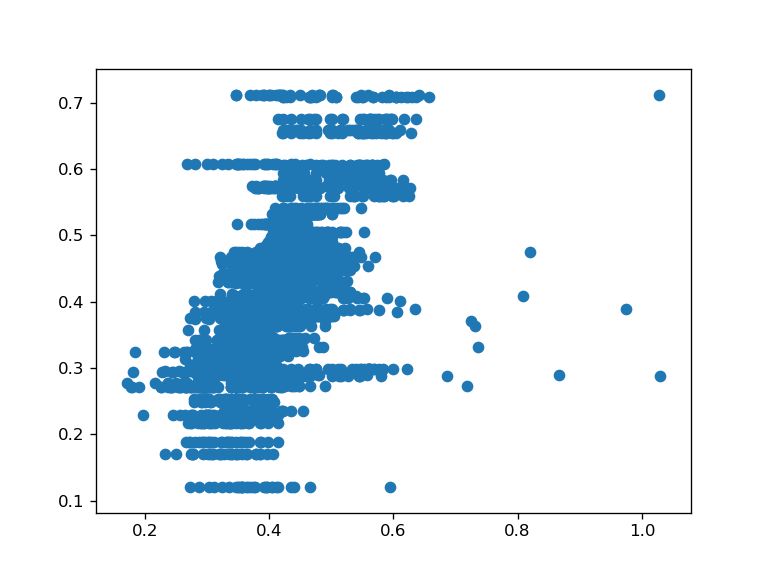

In [13]:

prog1 = FloatProgress(min=1, max=2,description='Running:')
prog2 = FloatProgress(min=0, max=100,description='Bootstrapping:')
MdLs = HTML(
    value=" ",
    placeholder='Models: ',
    description='Models: ',
)
MdL = HTML(
    value=" ",
    placeholder='Testing: ',
    description='Testing: ',
)
Display (tar,prog1,prog2,MdLs,MdL,kwt)

i = 0
j = 3
target = 'fco2'
params = Dense.Params(Scope,target,MP)
params['Dpath'] = cwd+'/'+Site+'/'
params['Spath'] = params['Dpath']+'ER/'+str(j)+'_'+str(i)+'/'
try:
    print(params['Spath'])
    os.mkdir(params['Spath'])
except:
    print('Noo')
    pass
params['Sname'] = 'Y_'
params['Inputs'] = ['AirTC_Avg','VWC','Temp']#Input
MdL.value='#'+str(i)+' '+str(params['Inputs'])
Display (tar,prog1,prog2,MdLs,MdL,kwt)
try:
    print(Level.sort_values('MSE'))
except:
    pass
# print('Runtime: ',time.time()-Time)
params['Model'] = '+'.join(params['Inputs'])
RST = RSTF.ReadStandardTimeFill(params,'ECData.csv')#,resample='2H')
if target == 'fco2':
    RST.Master = RST.Master.loc[RST.Master['PPFD_Avg']<10]
RST.Scale(params['target'],params['Inputs']) 
y = RST.y*1.0
X = RST.X*1.0
params['N']=int(y.shape[0]/30)
params['Memory'] = (math.floor(100/params['proc'])- 5/params['proc']) * .01
Y_hat=[]
y_true=[]
X_true=[]
index=[]
ones=[]
prog2.value=0
if MP == False:
    for k in range(params['K']):
        Time2 = time.time()
        results = Dense.Bootstrap(k,params,X,y)
        Y_hat.append(RST.YScaled.inverse_transform(results[0]))
        y_true.append(RST.YScaled.inverse_transform(results[1]))
        X_true.append(RST.XScaled.inverse_transform(results[2]))
        ones.append(results[3])
        prog2.value=(k+1)/params['K']*100
        print(time.time()-Time2)
else:
    pool = Pool(processes=processes,maxtasksperchild=75)
    for k,results in enumerate(pool.imap(partial(Dense.Bootstrap,params=params,X=X,y=y),range(params['K']))):
        Y_hat.append(RST.YScaled.inverse_transform(results[0]))
        y_true.append(RST.YScaled.inverse_transform(results[1]))
        X_true.append(RST.XScaled.inverse_transform(results[2]))
        ones.append(results[3])
        prog2.value=(k+1)/params['K']*100
    pool.close()
Y_hat = np.squeeze(np.asanyarray(Y_hat))
y_true = np.squeeze(np.asanyarray(y_true))
X_true = np.asanyarray(X_true)
ones = np.asanyarray(ones)
params['Memory'] = .95
if MP == False:
    for k in range(1):
         mse,se = Dense.Sort_outputs(k,params,Y_hat,y_true,X_true,ones)
else:
    pool = Pool(processes=1,maxtasksperchild=75)
    for k,results in enumerate(pool.imap(partial(Dense.Sort_outputs,params=params,
     Y_hat=Y_hat,y_true=y_true,X_true=X_true,ones=ones),range(1))):
         mse,se = results
    pool.close()
Level = Stats(mse,se,j,i,params)


Level.to_csv(params['Dpath']+'ER_Runs.csv')

<IPython.core.display.Javascript object>


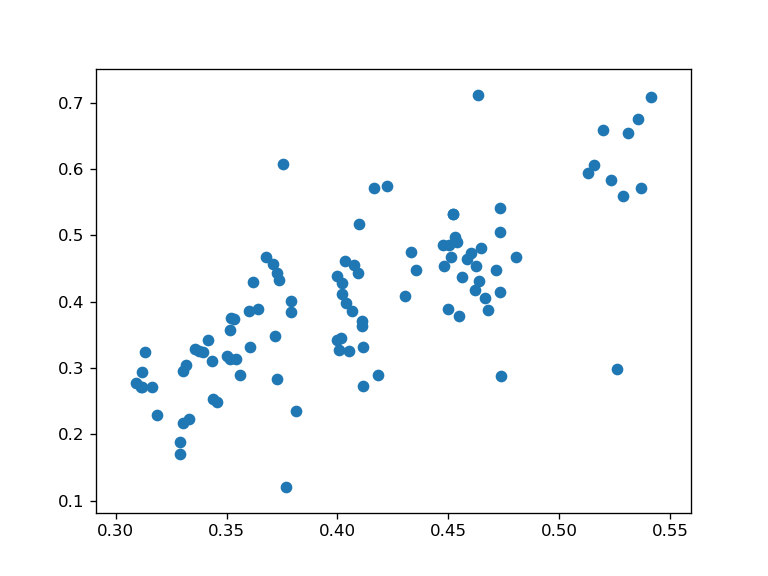

0.007279124415693276
0.49373750229359936


<IPython.core.display.Javascript object>


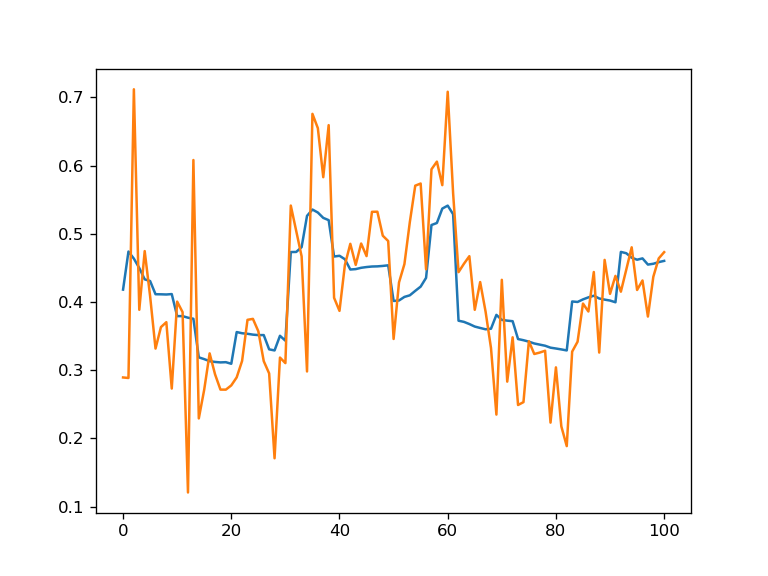

In [23]:
# Y_hat = Y_hat.mean(axis=0)
# y_true = y_true.mean(axis=0)

plt.figure()

plt.scatter(Y_hat,y_true)
print(metrics.mean_squared_error(y_true,Y_hat))
print(metrics.r2_score(y_true,Y_hat))

plt.figure()

plt.plot(Y_hat)
plt.plot(y_true)

# print(Y_hat.shape,y_true.shape)


# Predict

In [ ]:

plt.figure(figsize=(8,7))
Data = Data.sort_values(by=Key)
# Data.index = Data[Key]

Data = Data[np.isfinite(Data['True'])]

plt.scatter(RST.Master[Key],RST.Master[target],edgecolor='black',facecolor='white')
plt.plot(Data[Key],Data[target],
         label= params['target']+' Model\nr^2: '+str(np.round(metrics.r2_score(Data['True'],
                                                                   Data[params['target']])**2,3)))
# plt.plot(Data.index,Data['Var'],label= params['target']+
# ' Model\nRMSE: '+str(np.round(metrics.mean_squared_error(Data['True'],
#                                                                    Data[params['target']])**2,3)))


plt.fill_between(Data[Key], Data[target]-Data['PI'], 
                 Data[target]+Data['PI'],  color = 'green', alpha = 0.4, 
                 label = '95% PI')
plt.fill_between(Data[Key], Data[target]-Data['CI'], 
                 Data[target]+Data['CI'],  color = 'red', alpha = 0.4, 
                 label = '95% CI')
plt.legend()
# print(RST.Master)

plt.figure()

# plt.plot(Data[Key], Data['Var'])

plt.scatter(Data[target],Data['True'])

# print(Data['SE'])